<a href="https://colab.research.google.com/github/wkhalil/Ai-Learn/blob/master/Assignment_3_0301.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Supervised Learning: model training and evaluation

## *YUWEI ZHANG*
Netid: yz667

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), which is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

In [ ]:
%config InlineBackend.figure_format = 'retina'
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
import warnings

warnings.filterwarnings("ignore")
sns.set(style='white')
random.seed(705)

# Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Develop an understanding the optimal minimum misclassification error classifier (Bayes' classifier)

# 1
## [50 points] Classification using logistic regression: build it from the ground up

### I. Load, prepare, and plot your data
You are given some data for which you are tasked with constructing a classifier. The first step when facing any machine learning project: look at your data!

**(a)** Load the data. 
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class. 
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.

**ANSWER**

In [ ]:
# load_data
df = pd.read_csv("sample_data/A3_Q1_data.csv")
df

,x1,x2,y
0,2.553124,0.337757,0
1,-0.877757,0.045790,1
2,-0.903528,0.368076,1
3,-1.532152,-0.863737,1
4,-0.046954,-0.388761,1
...,...,...,...
195,1.378829,1.373243,0
196,-2.130029,-0.640655,1
197,-2.042915,-1.097198,1
198,-2.100484,-0.532332,1


- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  

**ANSWER**

In [ ]:
# Divide your data into a training and testing
df_train, df_test = train_test_split(df, test_size = 0.3, random_state=0, stratify=df["y"])
print('train\n',df_train.head(),'\n')
print('test\n',df_test.head())

train
            x1        x2  y
97   1.171522  0.212631  0
103  0.697209 -0.164482  0
57   0.388170 -1.405785  0
119 -0.135700 -0.707945  0
150 -0.172616 -1.193187  1 

test
            x1        x2  y
131 -0.726497 -2.260092  1
38  -1.258335 -1.394089  1
91   0.271738 -0.284378  1
93   0.883738 -0.478376  0
76  -1.714862 -3.143907  1


- Plot the training data by class.

**ANSWER**

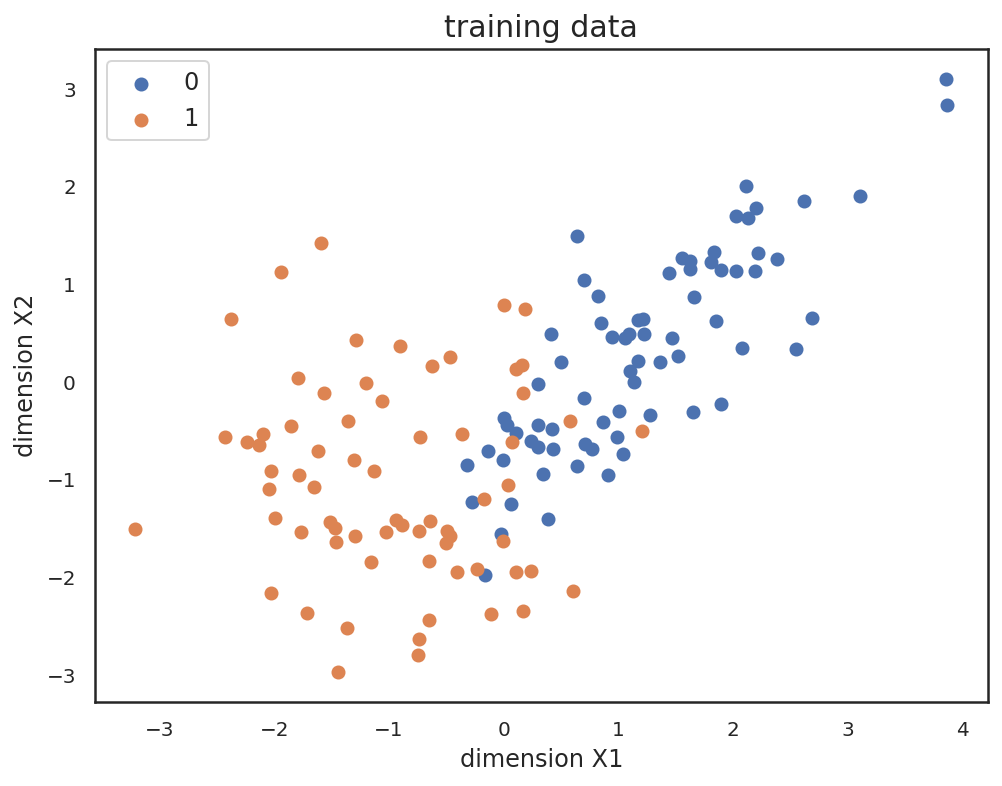

In [ ]:
# Plot the training data by class
plt.figure(figsize=(8,6))

# plot samples with label 0
plt.scatter(x=df_train.loc[df_train.y==0, "x1"],y=df_train.loc[df_train.y==0, "x2"], label="0")
# plot samples with label 1
plt.scatter(x=df_train.loc[df_train.y==1, "x1"],y=df_train.loc[df_train.y==1, "x2"], label="1")

# title,labels,legend
plt.title("training data",fontsize=15)
plt.xlabel("dimension X1",fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("dimension X2",fontsize=12)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.show()

In [ ]:
df_train

,x1,x2,y
97,1.171522,0.212631,0
103,0.697209,-0.164482,0
57,0.388170,-1.405785,0
119,-0.135700,-0.707945,0
150,-0.172616,-1.193187,1
...,...,...,...
62,-0.642483,-1.417103,1
79,0.821753,0.884801,0
138,-1.361070,-0.396913,1
154,0.169593,-2.346887,1


- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

> The data appears separable.

> Logistic regression may be a good choice for these data. <br />
There are 2 classes in total and there is a rough boundary between the 2 classes, indicating that the samples could be classified by a linear model.
Thus, logistic regression might be appropriate.

**(b)** Do the data require any preprocessing due to missing values, scale differences, etc.? If so, how did you handle these issues?

Next, we walk through our key steps for model fitting: choose a hypothesis set of models to train (in this case, logistic regression); identify a cost function to measure the model fit to our training data; optimize model parameters to minimize cost (in this case using gradient descent). Once we've completed model fitting, we will evaluate the performance of our model and compare performance to another approach (a KNN classifier).

**ANSWER**

In [ ]:
# checkf for missing data
df.isna().sum()

x1    0
x2    0
y     0
dtype: int64

In [ ]:
# check for statistic info
df.describe()

,x1,x2,y
count,200.000000,200.000000,200.000000
mean,0.151376,-0.385426,0.485000
std,1.411722,1.217490,0.501029
min,-3.210005,-3.193456,0.000000
25%,-0.912029,-1.341047,0.000000
50%,0.112286,-0.479684,0.000000
75%,1.174400,0.495114,1.000000
max,3.867647,3.103541,1.000000


> Since there's no missing value in each column, we don't need to pre-process missing values.

> Besides, the scale of the two features are similar, there's no need to rescale.

In [ ]:
# prepare array data
X_train = np.array(df_train.loc[:, ["x1", "x2"]].values)
y_train = np.array(df_train.loc[:, "y"].values)

X_test = np.array(df_test.loc[:, ["x1", "x2"]].values)
y_test = np.array(df_test.loc[:, "y"].values)

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression)

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a single training data pair $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the entire training dataset $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

**ANSWER**

$
\begin{equation}
\begin{split}
L(\mathbf{w}) &= \prod_{i=1}^{N}P(Y=1|X=x_i) \\
&= \prod_{i=1}^{N} \sigma(\mathbf{W^{\top}X})^{y_i}(1-\sigma(\mathbf{W^{\top}X}))^{1-y_i} \\
\sigma(\mathbf{W^{\top}x}) &= \frac{e^{\mathbf{W^{\top}x}}}{1+e^{\mathbf{W^{\top}x}}} \\
&= \frac{ e^{w_0 x_{0} + w_1 x_{1} + w_2 x_{2}}} 
{1+e^{w_0 x_{0} + w_1 x_{1} + w_2 x_{2}}}
\end{split}
\end{equation}
$

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood.

**ANSWER**

\begin{equation}
\begin{split}
\mathbf{C(w)} &= -\ln[\mathbf{L(W)}] \\
&= -\sum_{i=1}^{N} [y_i\ln[\sigma(\mathbf{W^{\top}X})] + (1-y_i)\ln[(1-\sigma{\mathbf{W^{\top}X}})]]\\
&= -\sum_{i=1}^{N} [y_i\mathbf{W^{\top}X} -\ln[1+e^{\mathbf{W^{\top}X}}]]
\end{split}
\end{equation}

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**ANSWER**

$
\nabla_{\mathbf{w}}C(\mathbf{w})
=
\begin{bmatrix}
\dfrac{\partial C}{\partial w_0}\\ 
\dfrac{\partial C}{\partial w_1}\\ 
\dfrac{\partial C}{\partial w_2} 
\end{bmatrix}
= \begin{bmatrix}
-\sum_{i=1}^{N}[y_i-\sigma(\mathbf{W^{\top}X})]x_0 \\
-\sum_{i=1}^{N}[y_i-\sigma(\mathbf{W^{\top}X})]x_1 \\
-\sum_{i=1}^{N}[y_i-\sigma(\mathbf{W^{\top}X})]x_2
\end{bmatrix}
$

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

**ANSWER**

$
\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \eta \nabla_{\mathbf{w}}C(\mathbf{w}^{(k)}) \\
= \mathbf{w}^{(k)} - \eta \begin{bmatrix}
-\sum_{i=1}^{N}[y_i-\sigma(\mathbf{W^{\top}X})]x_0 \\
-\sum_{i=1}^{N}[y_i-\sigma(\mathbf{W^{\top}X})]x_1 \\
-\sum_{i=1}^{N}[y_i-\sigma(\mathbf{W^{\top}X})]x_2
\end{bmatrix}
$

### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model. 
- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables.
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the average cost (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm. In doing this we'll need to make some assumptions about the following:
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? Set this to be when the cost function changes by no more than $10^{-6}$ between iterations OR when a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates). For the first criterion, since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations.
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

**ANSWER**

In [ ]:
# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        self.w = None     # logistic regression weights
        self.saved_w = [] # Since this is a small problem, we can save the weights
                          #  at each iteration of gradient descent to build our 
                          #  learning curves
        # returns nothing
        pass
    
    # Method for calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        # returns the value of the sigmoid
        return 1./(1+np.exp(-np.dot(X, w.T)))
    
    # Cost function for an input set of weights
    def cost(self, X, y, w):
        # returns the average cross entropy cost
        # get sigmoid
        z = self.sigmoid(X,w)
        
        # calculate cost
        cost = -np.dot(y, np.log(z)) - np.dot((1-y), np.log(1-z))
        return cost/X.shape[0]
    
    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        # returns s scalar of the magnitude of the Euclidean norm 
        #  of the change in the weights during one gradient descent step
        self.saved_w.append(self.w.copy())   # copy for deepcopy
        # calculate the diff
        delta_w = lr/X.shape[0]*np.dot(X.T, self.sigmoid(X,self.w)-y)
        
        # update & save w
        self.w -= delta_w
        
        # return the l2 norm of diff
        l2_norm = np.linalg.norm(delta_w.copy(), ord=2)
        return l2_norm
    
    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, w_init, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        # Note the verbose flag enables you to print out the weights at each iteration 
        #  (optional - but may help with one of the questions)
        
        # Weight initialization
        self.w = w_init.copy()    # copy for deepcopy, avoid id
        self.saved_w = []
        
        # gradient descent iterations
        for step in range(max_iter):
            l2_norm = self.gradient_descent(self.prepare_x(X),y,lr)
            if l2_norm <= delta_thresh:   # Stopping criteria
                break
        
        # returns nothing
        pass
    
    # Use the trained model to predict the confidence scores (prob of positive class in this case)
    def predict_proba(self, X):
        # returns the confidence score for the each sample
        # edge case
        if not self:
            raise Warning("please fit the model first")
        else:
            return self.sigmoid(self.prepare_x(X), self.w)
    
    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        # returns a binary prediction for each sample
        proba = self.predict_proba(X)
        return np.where(proba>= thresh, 1, 0)
    
    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        # returns the value of the cost function from each step in gradient descent
        #  from the last model fitting process
        
        cost_his = []
        # calculate cost from historical w
        for w in self.saved_w:
            cost = self.cost(self.prepare_x(X),y,w)
            cost_his.append(cost)
        
        return cost_his
    
    # Appends a column of ones as the first feature to account for the bias term
    def prepare_x(self, X):
        # returns the X with a new feature of all ones (a column that is the new column 0)
        # augment X for w0
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

**(h)** Choose a learning rate and fit your model. Show the learning curves for the gradient descent process for learning rates of $\{10^{-2}, 10^{-4}, 10^{-6}\}$. For each learning rate plot the learning curves by plotting the resulting cost as a function of each iteration of gradient descent. 
- Try running this process for a really big learning rate for this problem: $10^0$. Look at the weights that the fitting process generates over the first 50 iterations. What happens and why?
- What is the impact that the different values of learning has on the speed of the process and the results? 
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

**ANSWER**

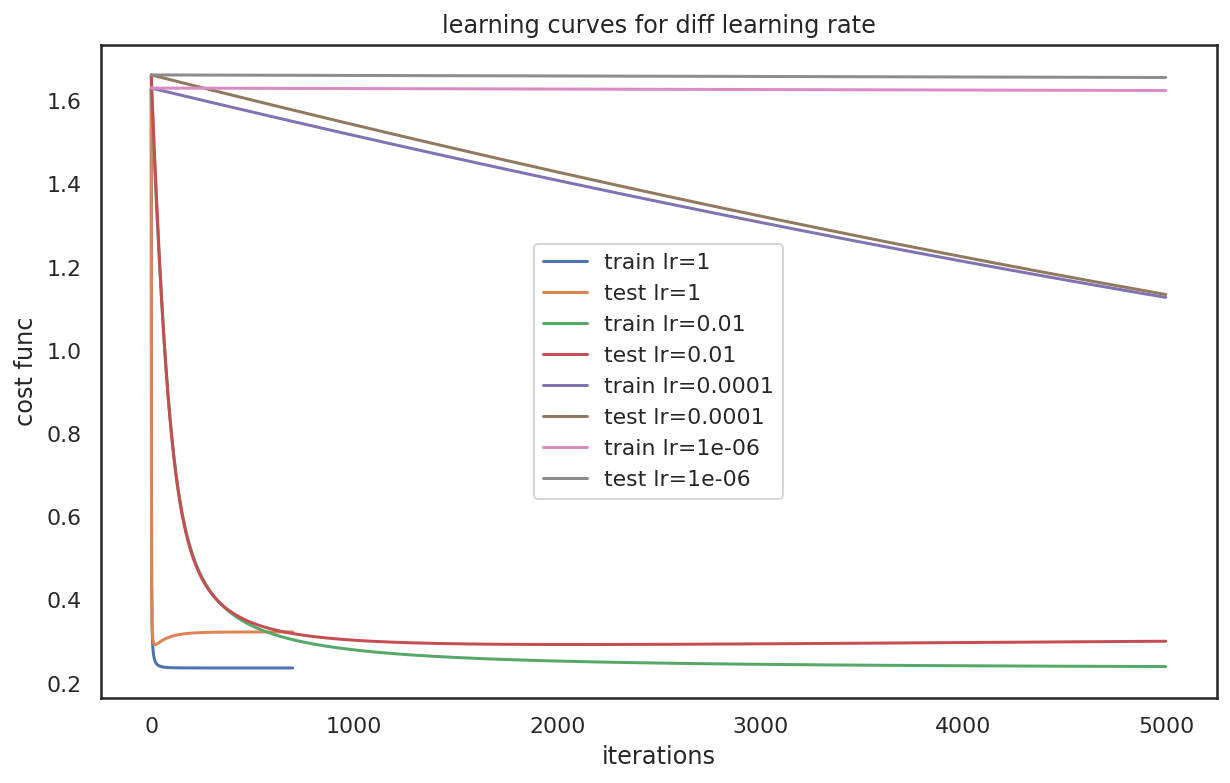

In [ ]:
lr_list = [1, 1e-2, 1e-4, 1e-6]

plt.figure(figsize = (10,6))

# numpy random seed only works for once
np.random.seed(705)
w_init = np.random.rand(X_train.shape[-1]+1,)    # +1 for w0

for lr in lr_list:
    clf = Logistic_regression()
    clf.fit(X_train, y_train, w_init, lr, delta_thresh=1e-6, max_iter=5000, verbose=False)
    train_costs = clf.learning_curve(X_train, y_train)
    plt.plot(train_costs, label = "train lr={}".format(lr))
    test_costs = clf.learning_curve(X_test, y_test)
    plt.plot(test_costs, label = "test lr={}".format(lr))

plt.legend()
plt.title("learning curves for diff learning rate")
plt.xlabel("iterations",fontsize=12)
plt.ylabel("cost func",fontsize=12)
plt.show()

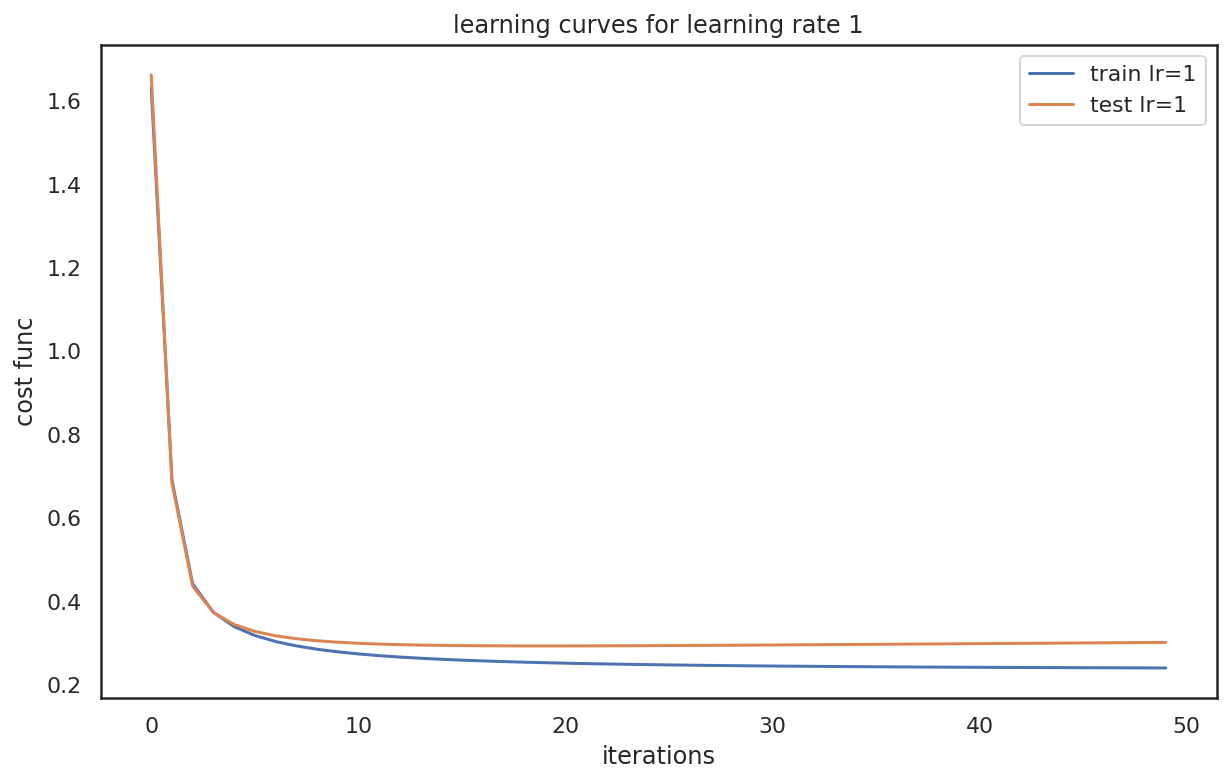

In [ ]:
lr = 1
plt.figure(figsize = (10,6))

np.random.seed(705)
w_init = np.random.rand(X_train.shape[-1]+1,)    # +1 for w0
clf = Logistic_regression()
clf.fit(X_train, y_train, w_init, lr, delta_thresh=1e-6, max_iter=50, verbose=False)
train_costs = clf.learning_curve(X_train, y_train)
plt.plot(train_costs, label = "train lr={}".format(lr))
test_costs = clf.learning_curve(X_test, y_test)
plt.plot(test_costs, label = "test lr={}".format(lr))

plt.legend()
plt.title("learning curves for learning rate {}".format(lr))
plt.xlabel("iterations",fontsize=12)
plt.ylabel("cost func",fontsize=12)
plt.show()

- Try running this process for a really big learning rate for this problem: $10^0$. Look at the weights that the fitting process generates over the first 50 iterations. What happens and why?
> We can see that the cost functions of training and test data drop rapidly at the beginning, then the cost function of test data started to increase while the cost function of training data drops slowly. <br />
Overfitting happens due to the large learning rate, since the w changes rapidly, the model rapidly approaches the optimal for training data, which captured the noise in training data and not perfect for test data.

- What is the impact that the different values of learning has on the speed of the process and the results? 
>The larger the learning rate, the faster the cost function drops at the beginning, and all the learning curves tend to reach the same cost function with infinite iterations at the end. <br />
For our training with 5000 iterations, we can see that learning curves of learning rate 1 and 1e-2 almost reach the same value, while 5000 iterations are not enough for 1e-4 and 1e-6 to converge.

- Of the options explored, what learning rate do you prefer and why?
>I choose 1e-2 as the learning rate since the model will converge relatively fast within 5000 iterations and does not overfit as fast as learning rate 1 does.

- Use your chosen learning rate for the remainder of this problem.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 
- Train your logistic regression model add a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make two plots corresponding to each model (logistic regression and KNN): one with the training data, and one for the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.
- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

- Train your logistic regression model add a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

lr_clf = Logistic_regression()
np.random.seed(705)
w_init = np.random.rand(X_train.shape[-1]+1,)    # +1 for w0
lr_clf.fit(X_train, y_train, w_init,lr = 1e-2, delta_thresh=1e-6, max_iter=1000, verbose=False)


knn_clf = KNeighborsClassifier(n_neighbors=7)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

- Using the trained models, make two plots corresponding to each model (logistic regression and KNN): one with the training data, and one for the test data. On each plot, include the decision boundary resulting from your trained classifier.

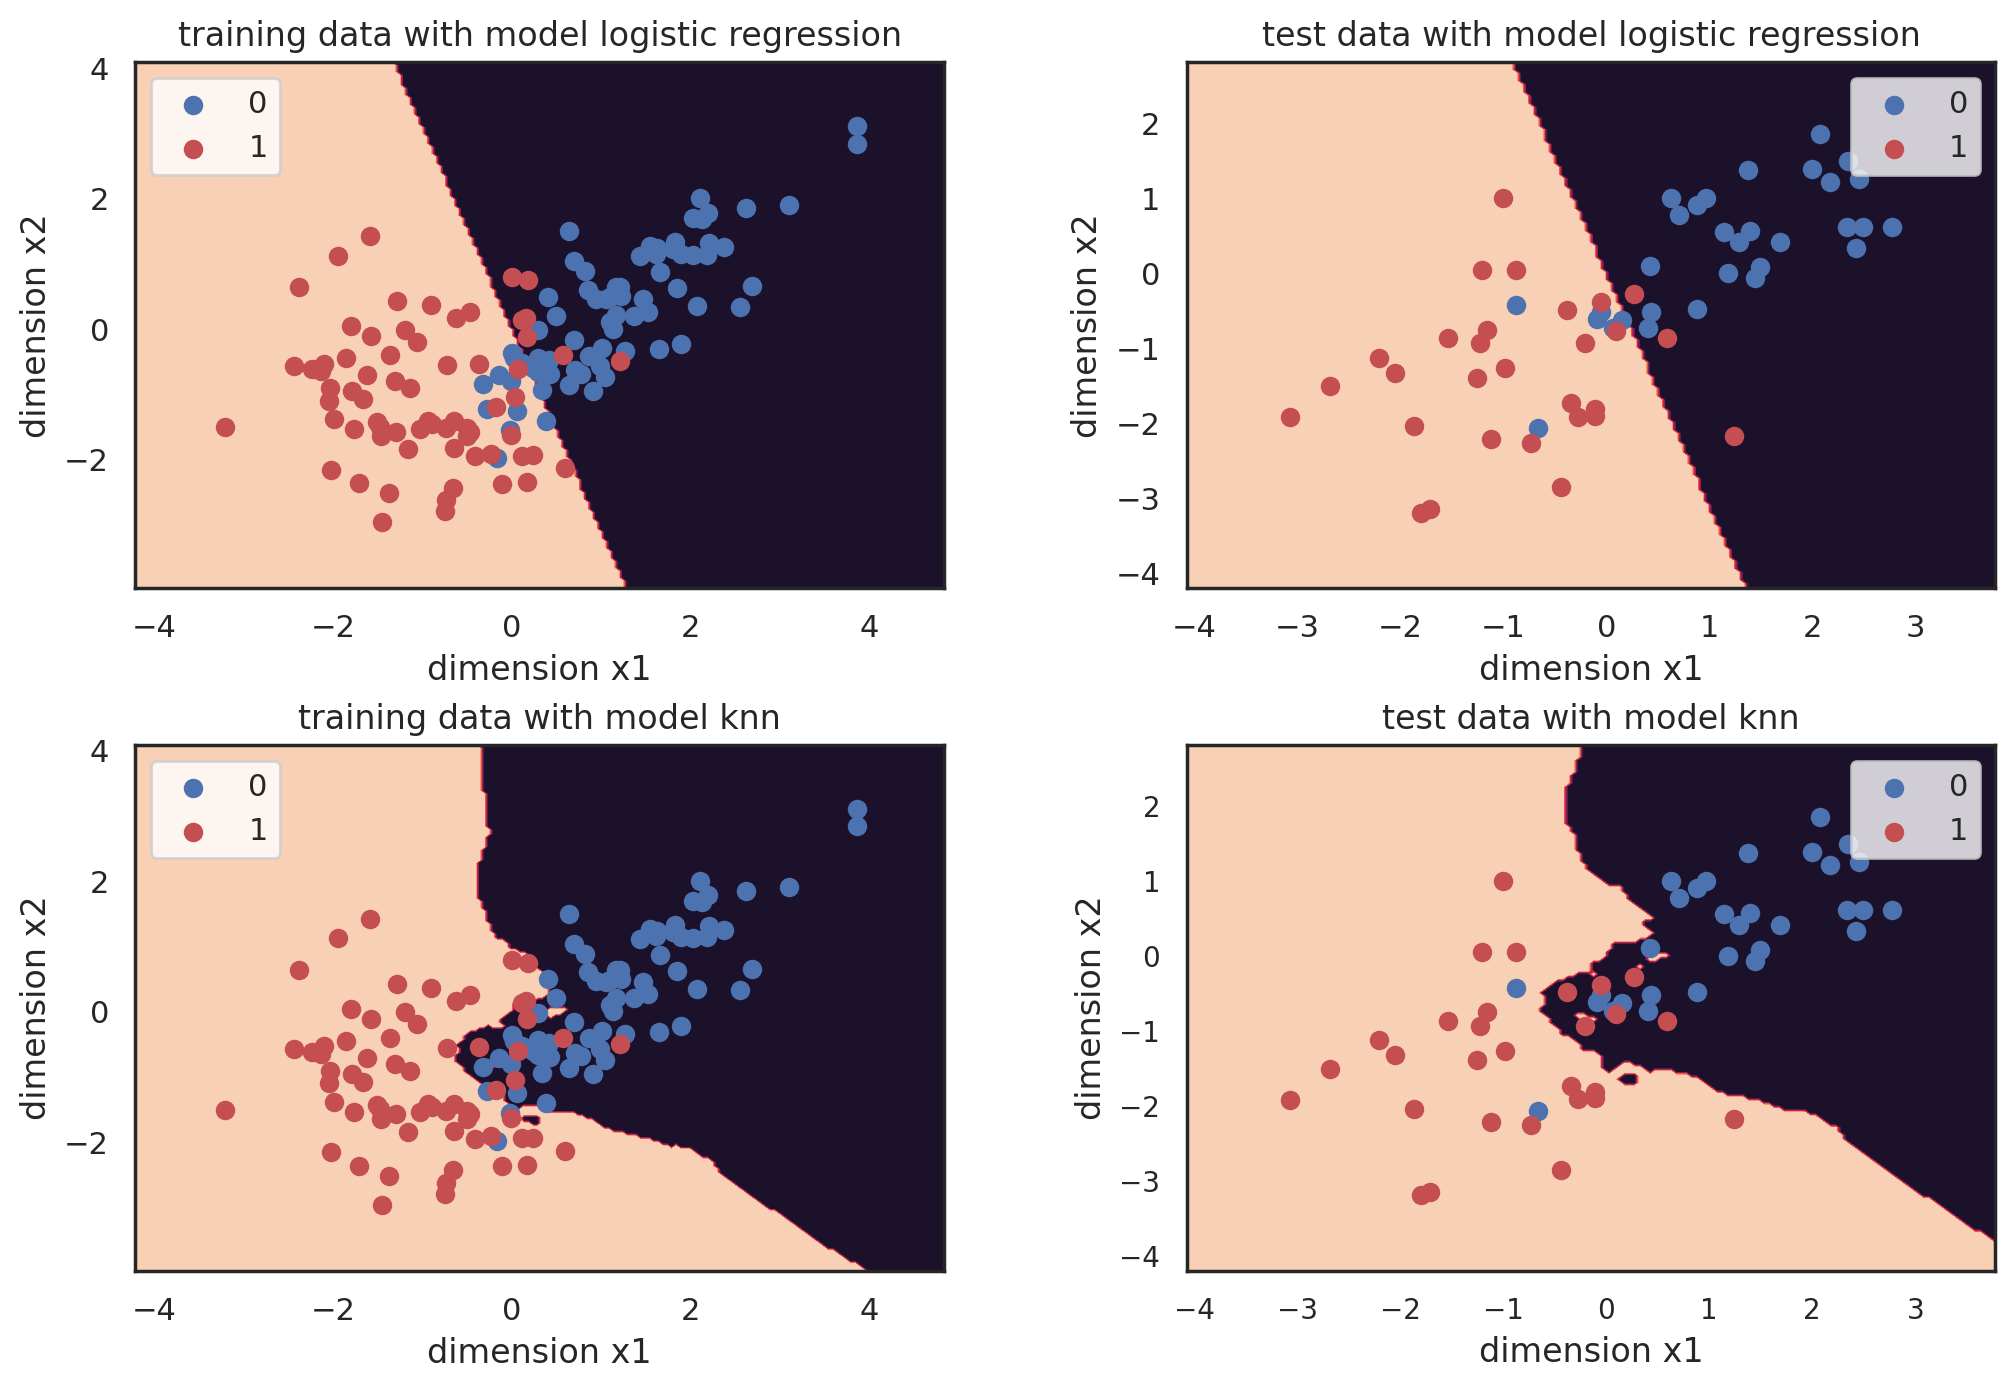

In [ ]:
def get_meshgrid(x,y):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx,yy= np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
    return xx,yy

figure ,axes =plt.subplots(2,2,figsize=(12,8),dpi=100)   # set subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adjust space between subplots

classifier_list = [lr_clf, knn_clf]
thresh = 0.5

row = 0
for clf in classifier_list:
    col = 0
    for df_clf in [df_train, df_test]:
        ax = axes[row][col]
        # plot decision boundary
        xx,yy = get_meshgrid(df_clf.loc[:, "x1"].values, df_clf.loc[:, "x2"].values)
        xxx = np.c_[xx.ravel(), yy.ravel()]
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z)

        # plot samples
        df_clf.y_c= np.where(df_clf.y>= thresh, 1, 0)
        df0 = df_clf[df_clf.y_c==0]
        df1 = df_clf[df_clf.y_c==1]
        ax.scatter(df0["x1"], df0["x2"], c="b", label="0")
        ax.scatter(df1["x1"], df1["x2"], c="r", label='1')
        ax.set_xlabel("dimension x1",fontsize=12)
        plt.xticks(fontsize=10)
        ax.set_ylabel("dimension x2",fontsize=12)
        plt.yticks(fontsize=10)
        ax.set_title("{} data with model {}".format("training" if not col else "test", "logistic regression" if not row else "knn"), fontsize=12)
        ax.legend()
        col += 1
    row += 1

- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10,random_state=705, shuffle=True)
skf_lr_pre = []
skf_knn_pre = []
skf_true = []

np.random.seed(705)
w_init = np.random.rand(X_train.shape[-1]+1,)    # +1 for w0

for train_index, validation_index in skf.split(X_train, y_train):
    X_train_skf, X_vali_skf = X_train[train_index], X_train[validation_index]
    y_train_skf, y_vali_skf = y_train[train_index], y_train[validation_index]
    
    lr_clf = Logistic_regression()
    lr_clf.fit(X_train_skf, y_train_skf, w_init,lr = 1e-2, delta_thresh=1e-6, max_iter=1000, verbose=False)
    skf_lr_pre.extend(lr_clf.predict_proba(X_vali_skf))
    
    knn_clf = KNeighborsClassifier(n_neighbors=7)
    knn_clf.fit(X_train_skf, y_train_skf)
    skf_knn_pre.extend(knn_clf.predict_proba(X_vali_skf)[:,1])    # first column for neg, senc for pos

    skf_true.extend(y_vali_skf)

Text(0.5, 1.0, 'k nearest neighbors ROC')

<Figure size 720x360 with 0 Axes>

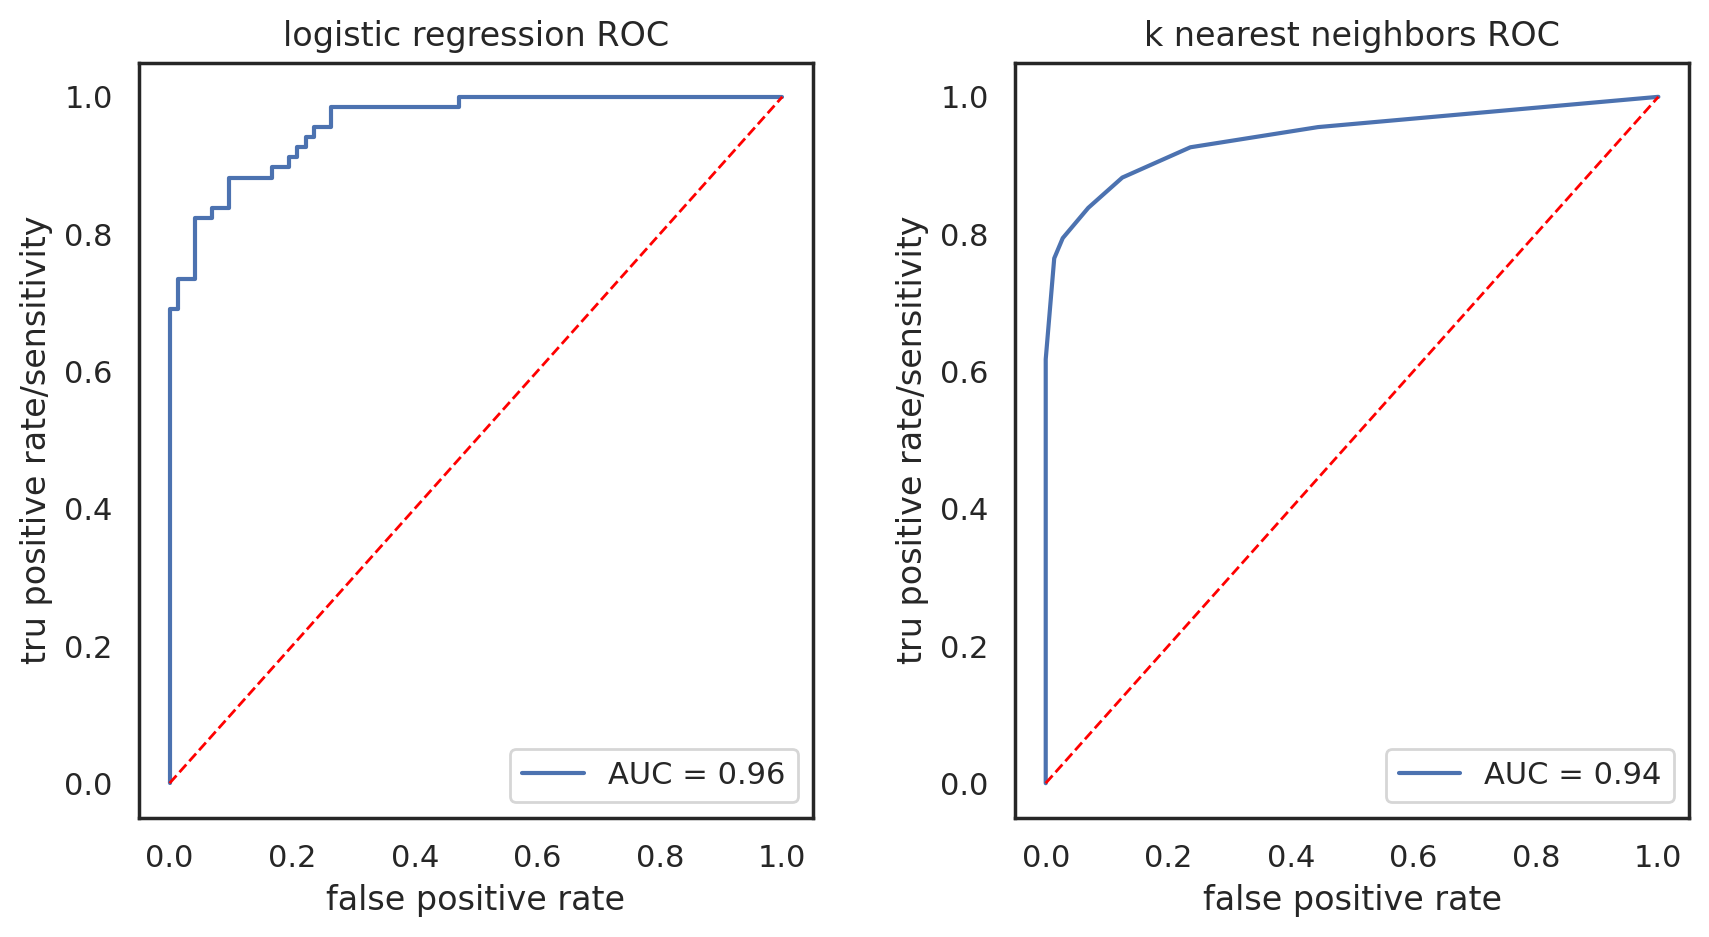

In [ ]:
plt.figure(figsize=(10,5))

figure ,axes =plt.subplots(1,2,figsize=(10,5),dpi=100)   # set subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adjust space between subplots

# LR
ax = axes[0]
fpr, tpr, thres = metrics.roc_curve(skf_true, skf_lr_pre, pos_label=1)
auc = metrics.roc_auc_score(skf_true, skf_lr_pre)
auc_label = "AUC = {:.02f}".format(auc)

ax.plot(fpr, tpr, label = auc_label)
ax.plot([0,1], [0,1], linestyle="--", linewidth=1, color='red')   # [x0,x1],[y0, y1]
ax.legend()
ax.set_xlabel("false positive rate")
ax.set_ylabel("tru positive rate/sensitivity")
ax.set_title("logistic regression ROC")


# LR
ax = axes[1]
fpr, tpr, thres = metrics.roc_curve(skf_true, skf_knn_pre, pos_label=1)
auc = metrics.roc_auc_score(skf_true, skf_knn_pre)
auc_label = "AUC = {:.02f}".format(auc)

ax.plot(fpr, tpr, label = auc_label)
ax.plot([0,1], [0,1], linestyle="--", linewidth=1, color='red')   # [x0,x1],[y0, y1]
ax.legend()
ax.set_xlabel("false positive rate")
ax.set_ylabel("tru positive rate/sensitivity")
ax.set_title("k nearest neighbors ROC")

- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

> The validation error in cross validation is a good approximation for test error. Hence, we could apply cross validation to model selection and evaluate the model generalization. Cross validation also enables us to obtain a good model despite limited data.

> From decision boundary, we could evaluate the flexibility of models and further check the possibility of overfitting. According to the decision boundary, the logistic regression is inflexible and less likely to overfit, while the knn is quite flexible and more likely to overfit. <br />
From ROC curve, we could see the model performance with different thresholds and evaluate the overall model performance by AUC. The larger the auc is, the better the model performance is. According to our result, the logistic regression and knn have similar ROC, but the AUC of logistic regression is slightly greater than that of KNN. Hence, I would select logistic regression on previously unseen data for its better generalization.

# 2

## [30 points] Digits classification
*An exploration of regularization, imbalanced classes, ROC and PR curves*

Load your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 

**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

**(b)** How many examples are present in each class? Show a histogram of samples by class. What fraction of samples are positive? What issues might this cause?

**(c)** Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at 20 different values of C. As you vary the regularization coefficient, Plot 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
- Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. 
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise your results may not converge
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [ ]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Set this to True to download the data for the first time and False after the first time 
#   so that you just load the data locally instead
download_data = True

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
    
    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y!='3'] = 0
    y[y=='3'] = 1
    y = y.astype('int')
    
    # Divide the data intro a training and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=88)
    
    file = open('tmpdata', 'wb')
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open('tmpdata', 'rb')
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()

**ANSWER**

**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

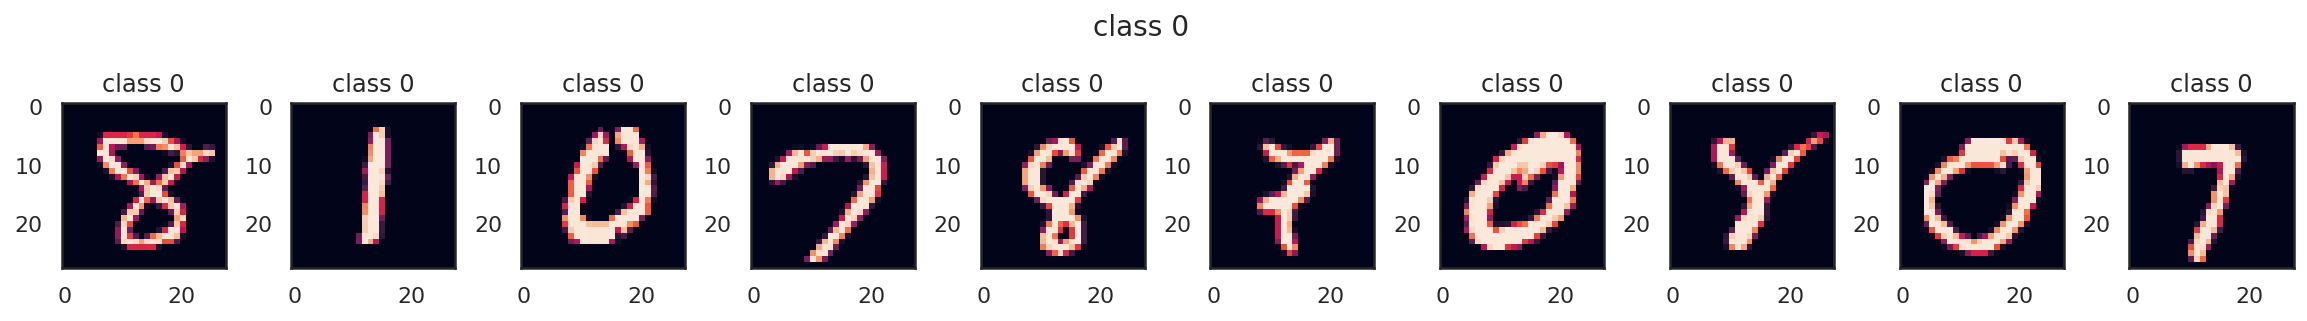

In [ ]:
# plot class y=0
fig, axes = plt.subplots(1,10,figsize=(20,2.5))
plt.subplots_adjust(wspace=0.4,hspace=0.4)
axes = axes.flatten()
for i in range(10):
    ax = axes[i]
    ax.imshow(X_train[y_train==0][i].reshape(28,28), interpolation='none')
    ax.set_title("class 0")
plt.suptitle("class 0",fontsize=14)
plt.show()

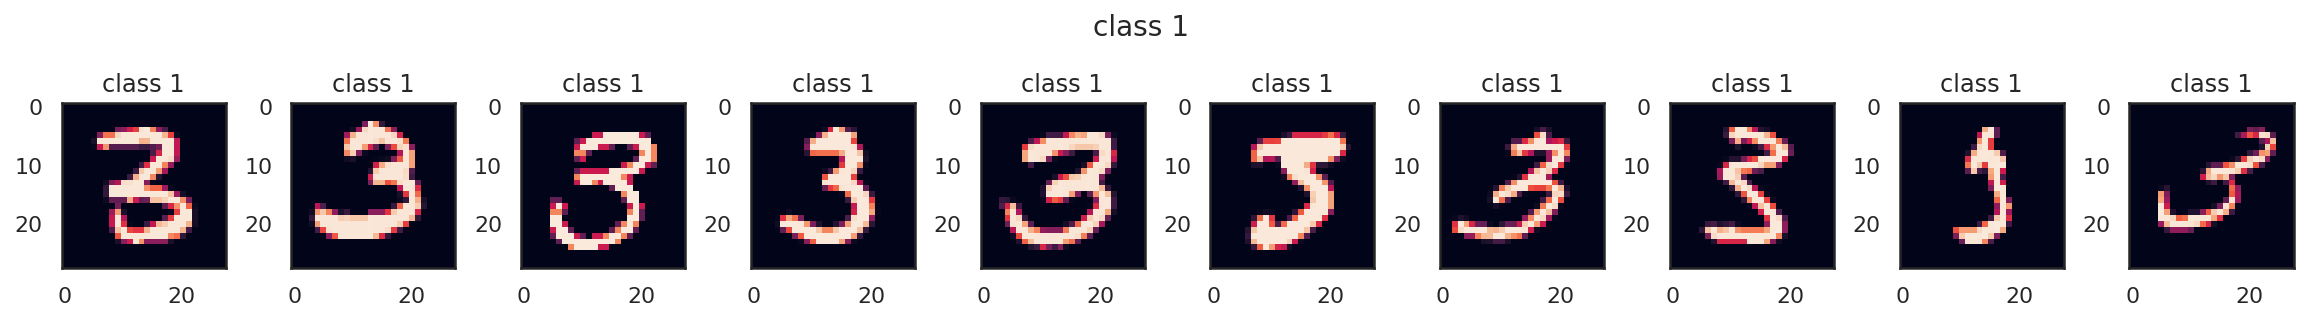

In [ ]:
# plot class y=1
fig, axes = plt.subplots(1,10,figsize=(20,2.5))
plt.subplots_adjust(wspace=0.4,hspace=0.4)
axes = axes.flatten()
for i in range(10):
    ax = axes[i]
    ax.imshow(X_train[y_train==1][i].reshape(28,28), interpolation='none')
    ax.set_title("class 1")
plt.suptitle("class 1",fontsize=14)
plt.show()

**(b)** How many examples are present in each class? Show a histogram of samples by class. What fraction of samples are positive? What issues might this cause?

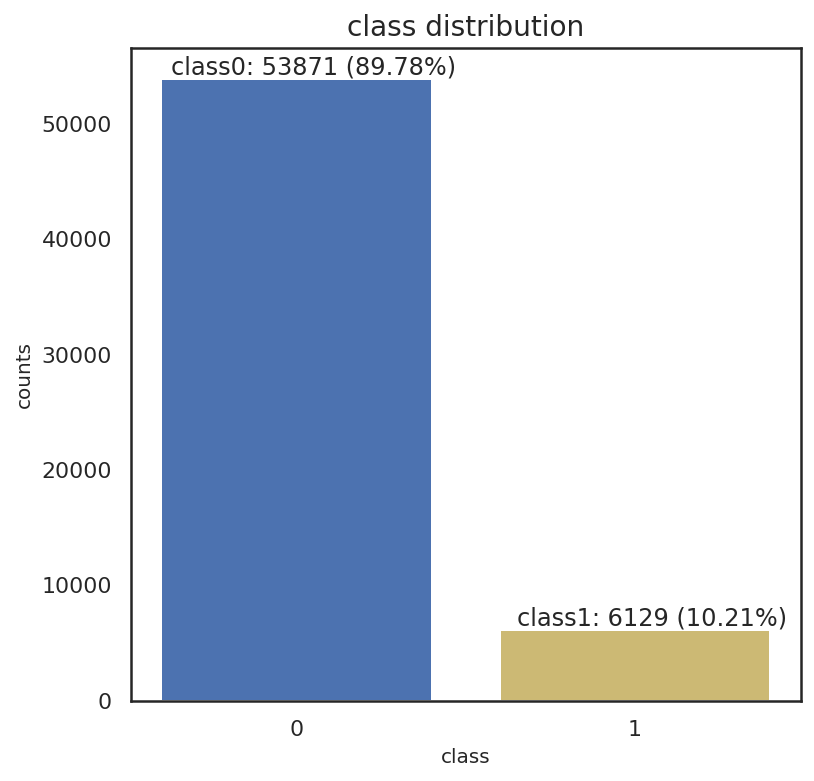

In [ ]:
plt.figure(figsize=(6,6))
class_counts = [sum(y_train==0), sum(y_train==1)]
plt.bar(range(2),class_counts, color=['b','y'])
plt.title("class distribution",fontsize=14)
plt.ylabel("counts",fontsize=10)
plt.xlabel("class",fontsize=10)
plt.xticks([0,1])

for x,y in zip(range(2),class_counts):
    plt.text(x+0.05,y+0.05,'class{}: {} ({:.02f}%)'.format(x,y,y/sum(class_counts)*100), ha='center',va='bottom')

>There are 53871 examples in class 0 and 6129 examples in class 1. <br />
That is, 89.78% of samples are negative, indicating unbalanced data. <br />
The unbalance might fit a model that tends to predict negative, or, tend to have a higher false positive rate.

**(c)** Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at 20 different values of C. As you vary the regularization coefficient, Plot 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
- Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

In [ ]:
from sklearn.linear_model import LogisticRegression

C_list = np.logspace(-4,4,20)
nonzero_list = []
logloss_list = []
test_logloss_list = []
roc_list = []
auc_list = []
f1_score_list = []

for C in C_list:
    lr_clf = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    lr_clf.fit(X_train, y_train)
    nonzero = sum(lr_clf.coef_[0]!=0)
    nonzero_list.append(nonzero)
    
    y_pre = lr_clf.predict(X_train)
    logloss = metrics.log_loss(y_train, y_pre)
    logloss_list.append(logloss)
    logloss_test = metrics.log_loss(y_test, lr_clf.predict(X_test))
    test_logloss_list.append(logloss_test)
    
    fpr, tpr, thres = metrics.roc_curve(y_train, y_pre)
    roc_list.append((fpr, tpr))
    
    auc = metrics.roc_auc_score(y_train, y_pre)
    auc_list.append(auc)
    
    f1_score = metrics.f1_score(y_train, y_pre)
    f1_score_list.append(f1_score)

Text(0, 0.5, 'f1-score')

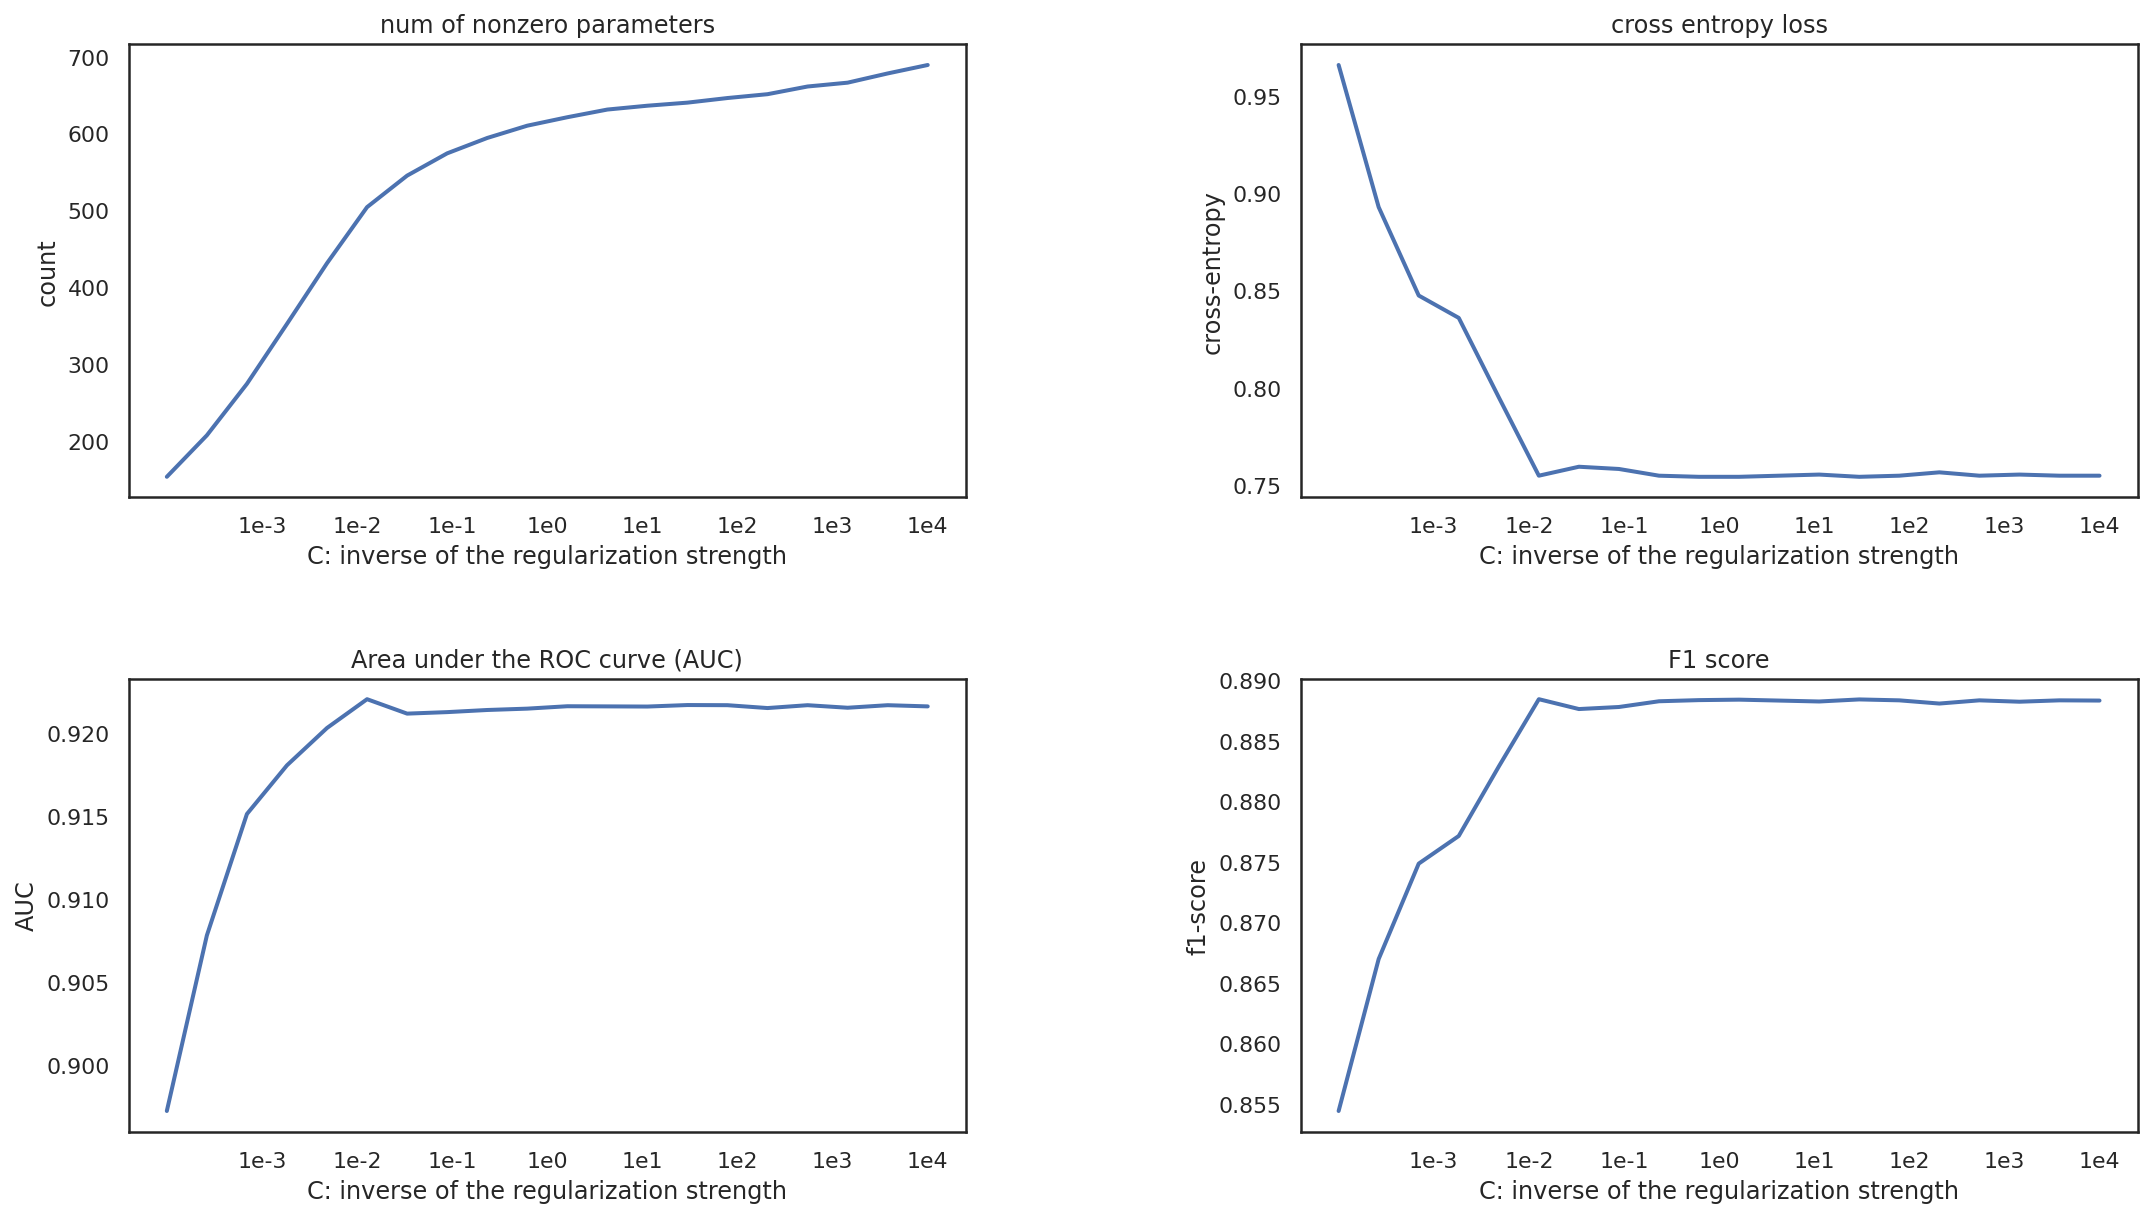

In [ ]:
# plot
fig, axes = plt.subplots(2,2,figsize=(18,10))
plt.subplots_adjust(wspace=0.4,hspace=0.4)
axes = axes.flatten()
i = 0
x_ticks = [1e-3,1e-2,1e-1,1,10,1e2,1e3,1e4]
x_labels = ['1e-3','1e-2','1e-1','1e0','1e1','1e2','1e3','1e4']

# number of model parameters that are estimated to be nonzero
ax = axes[i]
ax.plot(C_list, nonzero_list, linewidth=2)
ax.set_title("num of nonzero parameters",fontsize=12)
ax.set_xlabel("C: inverse of the regularization strength")
ax.set_xscale('log')    # xscale has to be put before xtixks or xticks will not work
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_ylabel("count")
i += 1

# cross entropy loss
ax = axes[i]
ax.plot(C_list, logloss_list, linewidth=2)
ax.set_title("cross entropy loss",fontsize=12)
ax.set_xlabel("C: inverse of the regularization strength")
ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_ylabel("cross-entropy")
i += 1

# Area under the ROC curve (AUC)
ax = axes[i]
ax.plot(C_list, auc_list, linewidth=2)
ax.set_title("Area under the ROC curve (AUC)",fontsize=12)
ax.set_xlabel("C: inverse of the regularization strength")
ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_ylabel("AUC")

i+= 1

# F1 score
ax = axes[i]
ax.plot(C_list, f1_score_list, linewidth=2)
ax.set_title("F1 score",fontsize=12)
ax.set_xlabel("C: inverse of the regularization strength")
ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_ylabel("f1-score")


>The 1e-2 seems the best C for the problem. <br />
Since all the lines have significant turns at similar C, which is approximately $10^{-2}$, and the model is relatively good and changes slowly after that.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. 
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise your results may not converge
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# X = np.vstack((X_train, X_test))
# sc = StandardScaler()
# sc.fit(X)
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

plt.figure(figsize=(10,6))

# (1) minimal regularization
lr_clf_mini = LogisticRegression(penalty='l1', solver='liblinear', C=10**100)
lr_clf_mini.fit(X_train, y_train)

LogisticRegression(C=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,
                   class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

<Figure size 720x432 with 0 Axes>

In [ ]:
# (2) best
lr_clf_best = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
lr_clf_best.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# (3) LDA
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
# (4) Random Forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

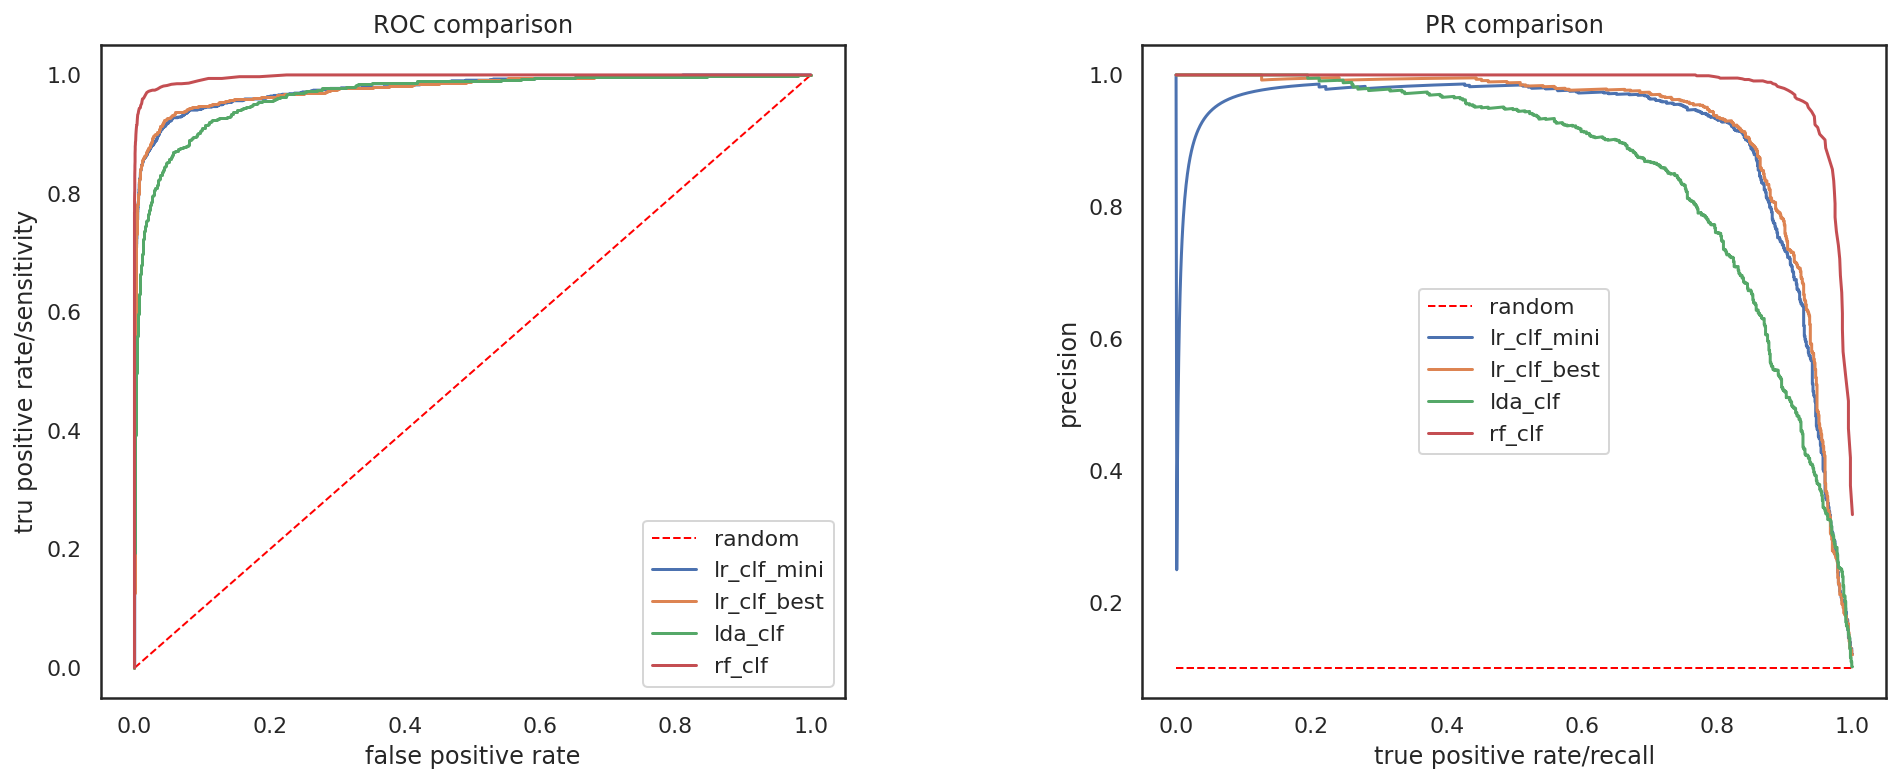

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
plt.subplots_adjust(wspace=0.4,hspace=0.4)
axes = axes.flatten()

# 0
axes[0].plot([0,1], [0,1], linestyle="--", linewidth=1, color='red', label="random")   # [x0,x1],[y0, y1]
p = sum(y_test==1)/y_test.shape[0]
axes[1].plot([0,1],[p,p],linestyle="--", linewidth=1, color='red', label="random")

# 1
y_pre = lr_clf_mini.predict_proba(X_test)[:,1]
fpr, tpr, thres = metrics.roc_curve(y_test, y_pre)
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pre)
axes[0].plot(fpr, tpr, label = "lr_clf_mini")
axes[1].plot(recall, precision,label = "lr_clf_mini")

# 2
y_pre = lr_clf_best.predict_proba(X_test)[:,1]
fpr, tpr, thres = metrics.roc_curve(y_test, y_pre)
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pre)
axes[0].plot(fpr, tpr, label = "lr_clf_best")
axes[1].plot(recall, precision,label = "lr_clf_best")

# 3
y_pre = lda_clf.predict_proba(X_test)[:,1]
fpr, tpr, thres = metrics.roc_curve(y_test, y_pre)
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pre)
axes[0].plot(fpr, tpr, label = "lda_clf")
axes[1].plot(recall, precision,label = "lda_clf")

# 4
y_pre = rf_clf.predict_proba(X_test)[:,1]
fpr, tpr, thres = metrics.roc_curve(y_test, y_pre)
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pre)
axes[0].plot(fpr, tpr, label = "rf_clf")
axes[1].plot(recall, precision,label = "rf_clf")

axes[0].legend()
axes[0].set_xlabel("false positive rate")
axes[0].set_ylabel("tru positive rate/sensitivity")
axes[0].set_title("ROC comparison")

axes[1].legend()
axes[1].set_xlabel("true positive rate/recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR comparison")

plt.show()

- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

> According to both ROC and PR curve, the random forest classifier has the best performance and the LDA classifier has the poorest performance according to the area under the lines and how closeness to the corners.

> In addition, the best logistic regression model is better than minimal logistic regression model, especially in PR curve, which is more appropriate on unbalanced data like MNIST Data. The regularization did make some difference, but not much. The reason might be the highly unbalanced data.

> Thus I would choose random forest classifier.

# 3

## [20 points] Comparing the Bayes' decision rule with logistic regression

The phrase "Bayes' decision rule" is often used to describe a classifier decision rule that minimizes misclassification rate (equally penalizing false positives and false negatives) for a given problem. In this exercise you will first determine the Bayes' decision rule for a binary classification problem where you know the likelihood of data from each class. 

This binary classification problem has two target classes with data distributed as exponential random variables:

$$P(x|C_i) = \lambda_i e^{-\lambda_i x}$$

Where $C_i$ represents the class from which the sample is drawn (0 or 1). This is known as the class-conditional likelihood, not surprisingly because it is the likelihood of the data conditioned on knowing what class it came from. This represents two separate density functions: one for the case when the class is 0 ($P(x|C_0)$)and one for when the class is 1 ($P(x|C_1)$). Assume that we know that $\lambda_0 = 5$ and $\lambda_1 = 1$ to fully-specify those distributions.

**(a)** Plot the probability of each class conditional distribution (e.g. likelihood function), $P(x|C_0)$ and $P(x|C_1)$ on the sample plot in the domain $x \in [0,2]$. *You can use [`scipy`'s `expon` module](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon) for this. Note that the `scale` parameter for this module is defined as $1/\lambda$.*

**(b)** Assuming the prior class distributions are $P(C_0)=P(C_1)=0.5$, determine the Bayes' decision rule using the information above. Remember that the Bayes Decision rule can be defined using the posterior distributions of the data; when $P(Y=1|x)>P(Y=0|x)$, predict Class 1, otherwise predict Class 0. In that way, you will assign the most probable class to the data based on the value of $x$. The decision rule will then be of the form: 

If $x > x^*$, then predict Class 1, otherwise predict Class 0

Determine the value $x^*$ that minimizes misclassification (equally penalizing false positives and false negatives, and no penalty/reward for correct detections). Show your work in deriving this value.

**(c)** How does your answer in (b) relate to the the plot you made in (a)?

**(d)** What if instead, $P(C_1)=2P(C_0)$; what would the new value of $x^*$ be in this case? Before computing the value, think through how you would expect it to change, then see if the math supports your conclusion.

**(e)** Load the test data in the file `A3_Q3_test.csv`, which follows the distributions above. Apply your Bayes decision rule to the data. What is the misclassification rate (error rate, or fraction of misclassified samples) of this decision rule? This should be the best that any algorithm could achieve (on average).

**(f)** Load the training data in the file `A3_Q3_train.csv` (which follows the distributions above) and train a logistic regression classifier on the data (using default parameters) from Scikit-Learn's `LogisticRegression` module. What is your misclassification error for your test dataset? How does this compare with the Bayes' classifier?

**(g)** What is your decision rule for the logistic regression model you just trained? To compute this, extract the parameters from your fit model (look for the `coef_` and `intercept_` attributes) and since the classes are balanced, the decision rule will be to classify a sample $x$ as Class 1 when your logistic regression sigmoid is greater than 0.5 (the halfway point from the two extremes of 0 and 1), since we assume $P(C_1|x)=\sigma(w_0 + w_1 x)$ in logistic regression. How does the decision rule from logistic regression compare with the Bayes' classifier?

**ANSWER**

**(a)** Plot the probability of each class conditional distribution (e.g. likelihood function), $P(x|C_0)$ and $P(x|C_1)$ on the sample plot in the domain $x \in [0,2]$. *You can use [`scipy`'s `expon` module](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon) for this. Note that the `scale` parameter for this module is defined as $1/\lambda$.*

Text(0, 0.5, '$P(x|C_i)$')

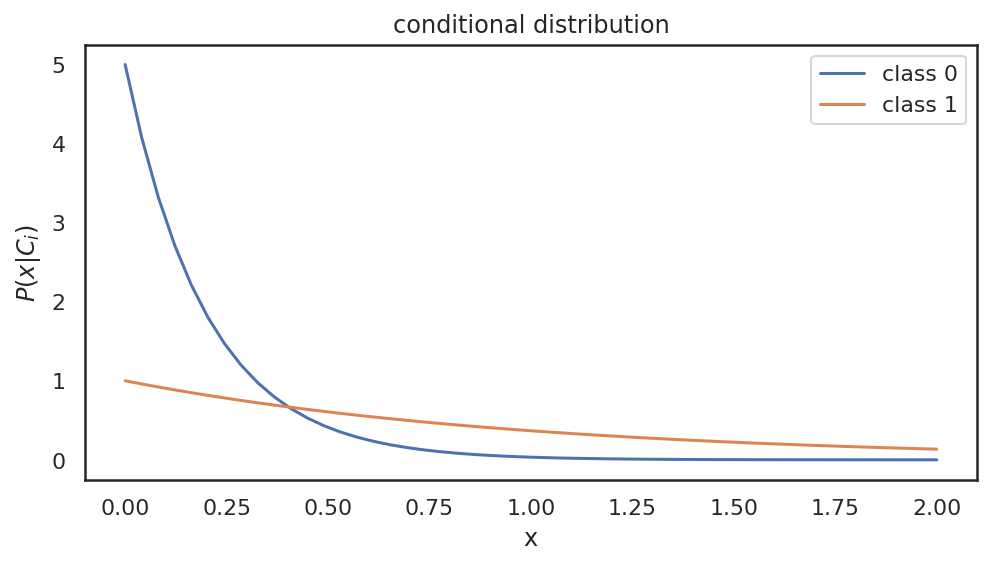

In [ ]:
import scipy

x = np.linspace(0,2)
lambda_0 = 5
lambda_1 = 1

plt.figure(figsize=(8,4))
pdf_0 = scipy.stats.expon.pdf(x, scale = 1/lambda_0)
plt.plot(x, pdf_0, label='class 0')

pdf_1 = scipy.stats.expon.pdf(x, scale = 1/lambda_1)
plt.plot(x, pdf_1, label='class 1')

plt.legend()
plt.title("conditional distribution")
plt.xlabel("x")
plt.ylabel("$P(x|C_i)$")

**(b)** Assuming the prior class distributions are $P(C_0)=P(C_1)=0.5$, determine the Bayes' decision rule using the information above. Remember that the Bayes Decision rule can be defined using the posterior distributions of the data; when $P(Y=1|x)>P(Y=0|x)$, predict Class 1, otherwise predict Class 0. In that way, you will assign the most probable class to the data based on the value of $x$. The decision rule will then be of the form: 

If $x > x^*$, then predict Class 1, otherwise predict Class 0

Determine the value $x^*$ that minimizes misclassification (equally penalizing false positives and false negatives, and no penalty/reward for correct detections). Show your work in deriving this value.

From Bayes rules, the posterior distribution
\begin{equation}
\begin{split}
P(C_0|x) = \frac{P(x|C_0)P(C_0)}{P(x)} = \frac{\lambda_0 e^{-\lambda_0x} \times 0.5}{\lambda_0 e^{-\lambda_0x}P(C_0) + \lambda_1 e^{-\lambda_1x}P(C_1)}
= \frac{5 e^{-5x} \times 0.5}{0.5 e^{-x} + 5 e^{-5x}\times 0.5} = \frac{5}{e^{4x} + 5}
\end{split} 
\end{equation}
\begin{equation}
\begin{split}
P(C_1|x) = \frac{P(x|C_1)P(C_1)}{P(x)} = \frac{\lambda_1 e^{-\lambda_1x} \times 0.5}{\lambda_0 e^{-\lambda_0x}P(C_0) + \lambda_1 e^{-\lambda_1x}P(C_1)}
= \frac{e^{-x} \times 0.5}{0.5 e^{-x} + 5 e^{-5x}\times 0.5} = \frac{e^{4x}}{e^{4x} + 5}
\end{split} 
\end{equation}
<br />
Since the decision rule If $x > x^*$, then predict Class 1, otherwise predict Class 0. <br />
combined with posterior distribution:
\begin{equation}
\begin{split}
P(C_1|x) > P(C_0|x)\\
then \frac{e^{4x}}{e^{4x} + 5} > \space \frac{5}{e^{4x} + 5} \\
then \space e^{8x}>25 \\
\end{split} 
\end{equation}
thus the decision boudary $ x^* = \frac{1}{8} \ln(25) \approx 0.402$ minimizes misclassification (equally penalizing false positives and false negatives, and no penalty/reward for correct detections). Show your work in deriving this value.


**(c)** How does your answer in (b) relate to the the plot you made in (a)?
> The (b) is a special case that the prior distribution of class 0 and class 1 are equal(0.5). <br />
For x which is larger than 0.402, there is a larger likelihood of class 1 than class 0; while x is smaller than 0.402, there is a larger likelihood of class 0 than class1; the likelihood of class 0 and class 1 quals while x=0.402.

**(d)** What if instead, $P(C_1)=2P(C_0)$; what would the new value of $x^*$ be in this case? Before computing the value, think through how you would expect it to change, then see if the math supports your conclusion.
> since the likelihood of class 1 becomes larger, x would be more likely to be classified into class 1 and the decision boundary would be less than 0.402.
\begin{equation}
\begin{split}
&P(C_1|x) > P(C_0|x)\\
&then \frac{2e^{4x}}{2e^{4x} + 5} > \space \frac{5}{2e^{4x} + 5}\\
&then \space e^{4x}>\frac{5}{2}\\
\end{split} 
\end{equation}
thus the decision boudary becomes $ x^* = \frac{1}{4} \ln(2.5) \approx 0.229$,smaller than 0.402, which is consistent with the inference.

**(e)** Load the test data in the file `A3_Q3_test.csv`, which follows the distributions above. Apply your Bayes decision rule to the data. What is the misclassification rate (error rate, or fraction of misclassified samples) of this decision rule? This should be the best that any algorithm could achieve (on average).

In [ ]:
df_test = pd.read_csv("sample_data/A3_Q3_test.csv", index_col=0)
df_test

,x,y
0,0.015908,0
1,0.104710,0
2,0.050695,0
3,1.604109,1
4,3.079131,1
...,...,...
19995,0.098668,0
19996,1.304005,1
19997,0.267137,0
19998,0.138392,0


In [ ]:
df_test["y_pre"] = 0
df_test.loc[df_test.x > 1/8*np.log(25), "y_pre"] = 1
miss_class_rate = sum(df_test.y != df_test.y_pre)/len(df_test)
print("the misclassification rate is {}".format(miss_class_rate))

the misclassification rate is 0.23395


**(f)** Load the training data in the file `A3_Q3_train.csv` (which follows the distributions above) and train a logistic regression classifier on the data (using default parameters) from Scikit-Learn's `LogisticRegression` module. What is your misclassification error for your test dataset? How does this compare with the Bayes' classifier?

In [ ]:
df_train = pd.read_csv("sample_data/A3_Q3_train.csv", index_col=0)
df_train

,x,y
0,1.159079,1
1,1.226236,1
2,1.795447,1
3,1.781118,1
4,0.145231,0
...,...,...
199995,0.092684,1
199996,0.030091,0
199997,0.023817,0
199998,0.008565,0


In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(df_train.x.values.reshape(-1,1), df_train.y.values)
y_pre = lr_clf.predict(df_test.x.values.reshape(-1,1))
acc = metrics.accuracy_score(df_test.y.values, y_pre)
error_rate = 1-acc
print("the misclassification rate of logistic regression is {:.06f}".format(error_rate))

the misclassification rate of logistic regression is 0.234000


> The misclassification rate of logistic regression (0.234) is slightly larger than that of Bayes' classifier (0.23395).

**(g)** What is your decision rule for the logistic regression model you just trained? To compute this, extract the parameters from your fit model (look for the `coef_` and `intercept_` attributes) and since the classes are balanced, the decision rule will be to classify a sample $x$ as Class 1 when your logistic regression sigmoid is greater than 0.5 (the halfway point from the two extremes of 0 and 1), since we assume $P(C_1|x)=\sigma(w_0 + w_1 x)$ in logistic regression. How does the decision rule from logistic regression compare with the Bayes' classifier?

In [ ]:
coef = lr_clf.coef_[0][0]
intercept = lr_clf.intercept_[0]
decision_b = - intercept/coef
print("the decision boundary is {:.03f}".format(decision_b))

the decision boundary is 0.403


> The decision rule for the logistic regression model: if x>0.403, predict class 1; else predict class 0.<br />
The decision rule is almost the same as the Bayes decision rule, the best for minimizing the misclassification error.